- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
-  

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import pandas as pd
import numpy as np

from ML_loader import DatasetLoader,ModelLoader


In [2]:
#Get data 
loader = DatasetLoader()
loader.read_dataset('partial_database.csv',class_path='labelsDefault.txt',separator=',')
loader.split_dataset()

#Normalize data, if not already normalized
print(np.shape(loader.X_train),np.shape(loader.X_test),np.shape(loader.y_train),np.shape(loader.y_test))

(4048, 17) (1012, 17) (4048,) (1012,)


In [3]:
#Get model
model = ModelLoader()
model.set_model(MultinomialNB())

cv = RepeatedStratifiedKFold(n_splits=22, n_repeats=3, random_state=1)

#Optimization 
param = {'alpha': np.linspace(0.5, 1.5, 6),
            'fit_prior': [True, False]}

model.set_optimal_params(param)

model.optimize(loader.X_train,loader.y_train,cv=cv,scoring='accuracy',n_iter=10)

#Train model with optimal params
model.set_model(MultinomialNB(**model.optimal_params))


Partial fit
Score accuracy group 0:  0.8105590062111802
Score accuracy group learned 0:  0.8105590062111802
Score accuracy global:  0.2658102766798419
Memory:  159.0078125 MB
Partial fit
Score accuracy group 1:  0.9239130434782609
Score accuracy group learned 0:  0.7763975155279503
Score accuracy group learned 1:  0.9239130434782609
Score accuracy global:  0.34288537549407117
Memory:  184.91796875 MB
Partial fit
Score accuracy group 2:  0.5978260869565217
Score accuracy group learned 0:  0.6490683229813664
Score accuracy group learned 1:  0.9130434782608695
Score accuracy group learned 2:  0.5978260869565217
Score accuracy global:  0.4160079051383399
Memory:  191.2265625 MB
Partial fit
Score accuracy group 3:  0.5652173913043478
Score accuracy group learned 0:  0.6180124223602484
Score accuracy group learned 1:  0.9130434782608695
Score accuracy group learned 2:  0.5652173913043478
Score accuracy group learned 3:  0.5652173913043478
Score accuracy global:  0.47035573122529645
Memory:  

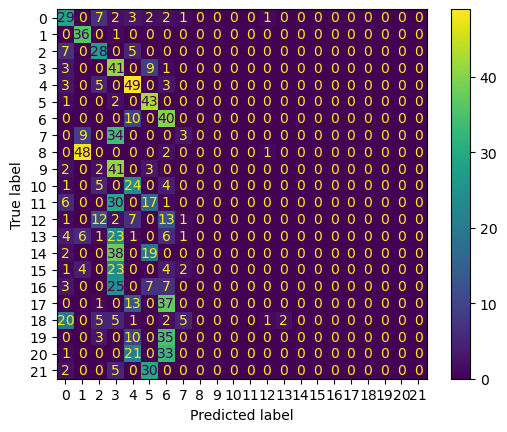

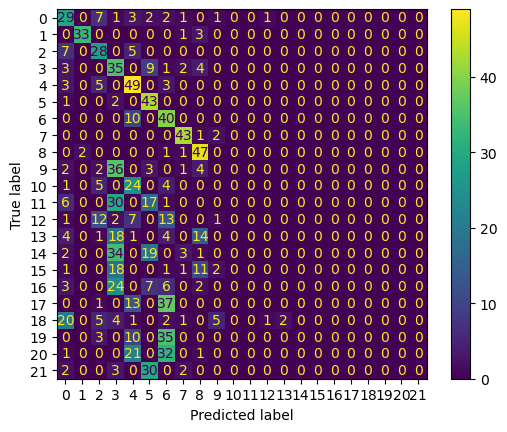

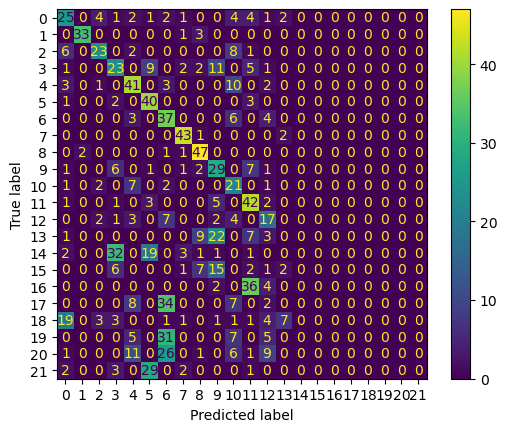

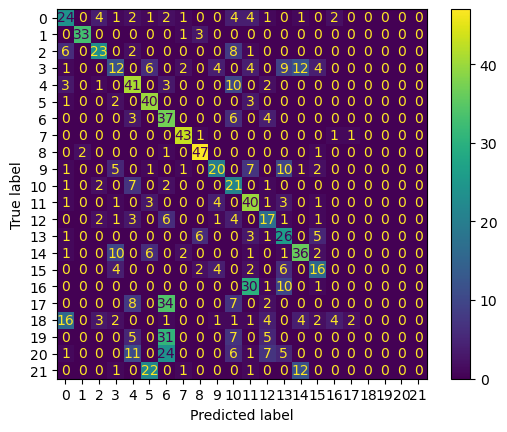

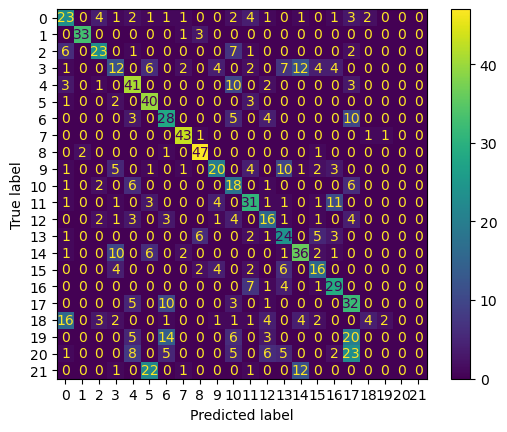

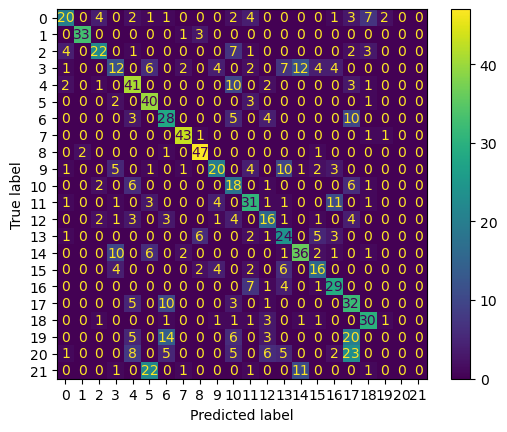

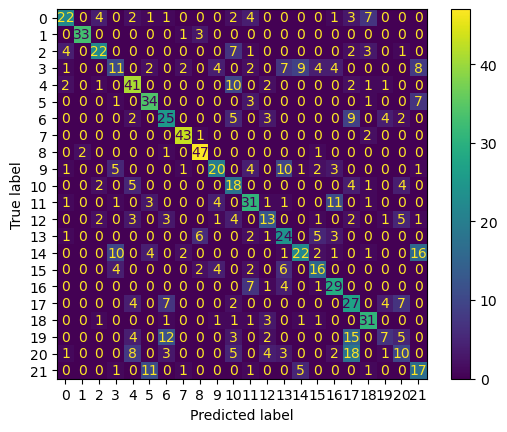

In [4]:
##Split by class, to increment by class:
class_to_group = {1:[1,2,3,4,5,6,7],2:[8,9],3:[10,11,12,13],4:[14,15,16],5:[17,18],6:[19],7:[20,21,22]}
X_train_merged, X_test_merged, y_train_merged, y_test_merged=loader.split_dataset_class(class_to_group,random_state=1)
memory_values = []

#Train model
for idx,(X_train,y_train,X_test,y_test) in enumerate(zip(X_train_merged,y_train_merged,X_test_merged,y_test_merged)):
    mem,res=model.partial_fit_train(X_train,y_train,classes=loader.classes)
    print(f"Score accuracy group {idx}: ",model.score(X_test,y_test))
    for i in range(idx+1):
        print(f"Score accuracy group learned {i}: ",model.score(X_test_merged[i],y_test_merged[i]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))
    
    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")

Partial fit
Score accuracy batch 0:  0.5395256916996047
Score accuracy global:  0.5345849802371542
Memory:  241.08203125 MB
Partial fit
Score accuracy batch 1:  0.5335968379446641
Score accuracy global:  0.5375494071146245
Memory:  229.3828125 MB
Partial fit
Score accuracy batch 2:  0.5395256916996047
Score accuracy global:  0.5395256916996047
Memory:  231.3984375 MB
Partial fit
Score accuracy batch 3:  0.5573122529644269
Score accuracy global:  0.5395256916996047
Memory:  231.8984375 MB
Partial fit
Score accuracy batch 4:  0.5592885375494071
Score accuracy global:  0.5395256916996047
Memory:  232.99609375 MB
Partial fit
Score accuracy batch 5:  0.5592885375494071
Score accuracy global:  0.5395256916996047
Memory:  234.81640625 MB
Partial fit
Score accuracy batch 6:  0.5513833992094862
Score accuracy global:  0.5385375494071146
Memory:  236.16796875 MB
Partial fit
Score accuracy batch 7:  0.5276679841897233
Score accuracy global:  0.5385375494071146
Memory:  237.66015625 MB
Partial fit

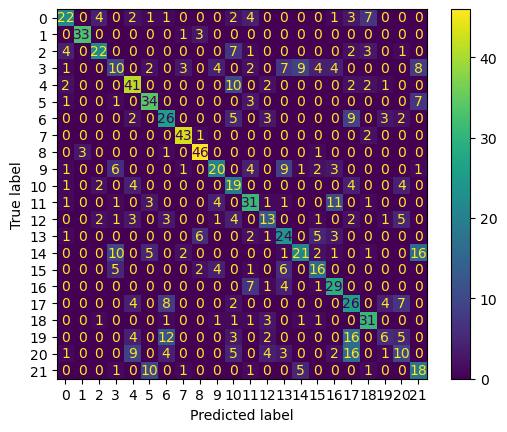

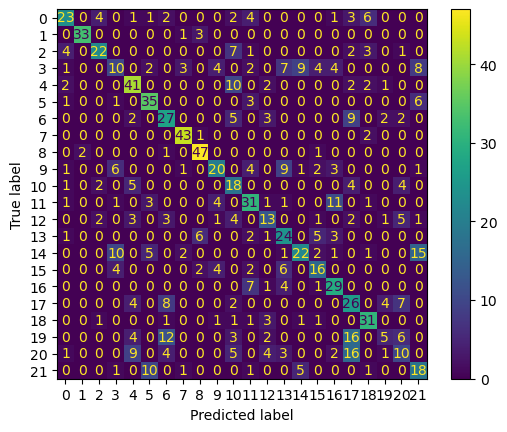

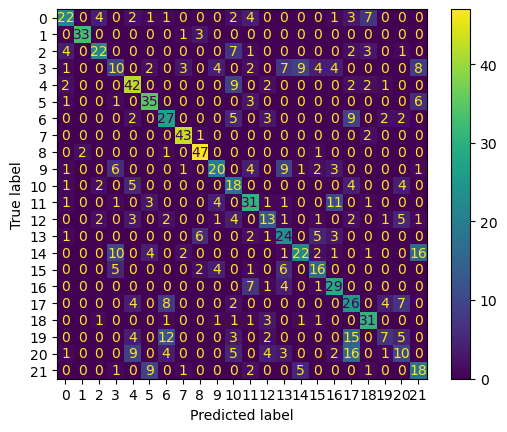

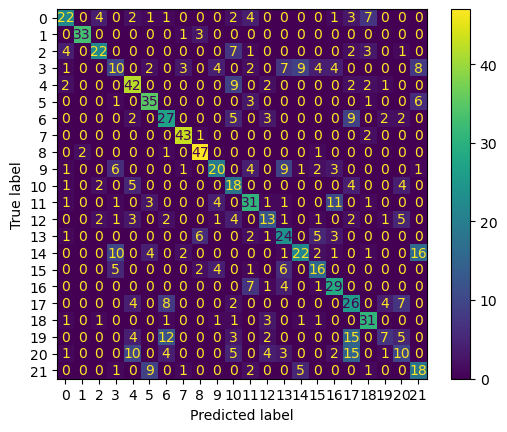

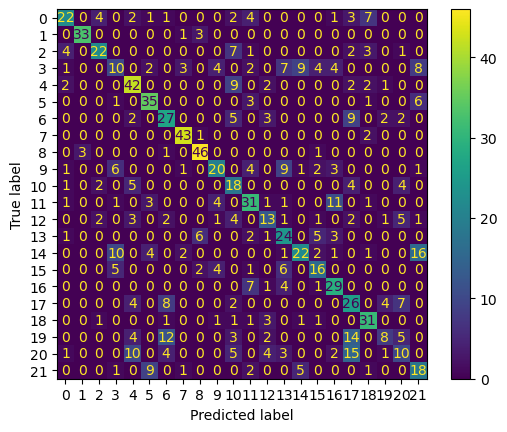

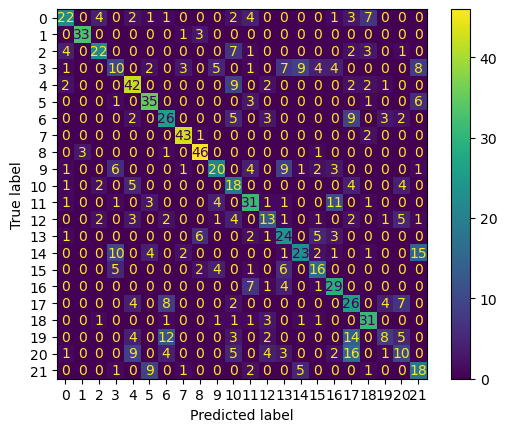

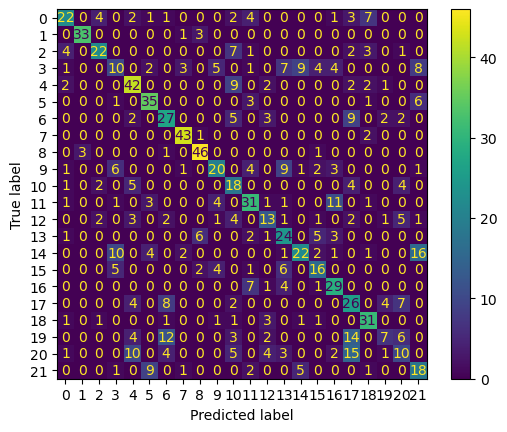

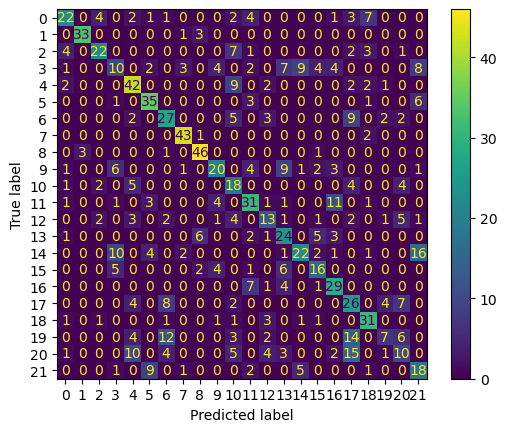

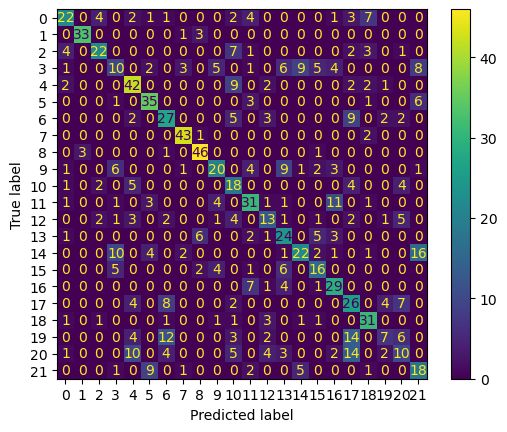

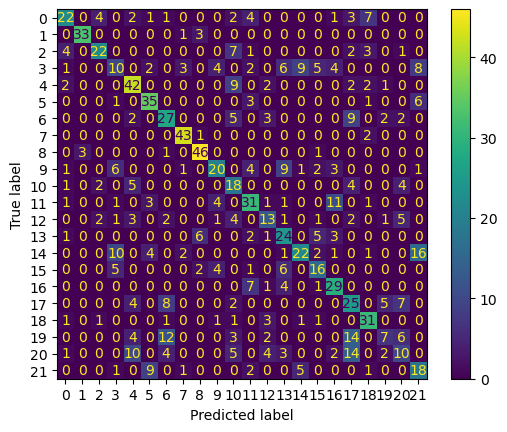

In [5]:
X_train_split_data,y_train_split_data,X_test_split_data,y_test_split_data=loader.split_dataset_data(10,random_state=1)
memory_values = []

for x in range(len(X_train_split_data)):
    mem,res=model.partial_fit_train(X_train_split_data[x],y_train_split_data[x],classes=loader.classes)
    print(f"Score accuracy batch {x}: ",model.score(X_test_split_data[x],y_test_split_data[x]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))

    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")